In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import osmnx as ox
import networkx as nx
from scipy import spatial
from sklearn.cluster import KMeans

In [2]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
cal_true_traffics = np.load("cal_true_traffics.npy")
cal_pred_traffics = np.load("cal_pred_traffics.npy")
test_pred_traffics = np.load("test_pred_traffics.npy")

In [4]:
G = ox.graph_from_place("Manhattan, New York City, New York", network_type="drive")

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [5]:
k = 10
alpha = 0.05

c_cal_tiled = np.transpose(np.tile(cal_true_traffics, (k, 1, 1)), (1, 0, 2))
c_cal_diff = cal_pred_traffics - c_cal_tiled
c_cal_norms = np.linalg.norm(c_cal_diff, axis=-1)
c_cal_scores = np.min(c_cal_norms, axis=-1)

conformal_quantile = np.quantile(c_cal_scores, q = 1 - alpha)

In [65]:
def get_rps_cc(N_rps, regions_samples):
    total_covered = np.sum([len(region_samples) for region_samples in regions_samples])
    total_rps = 0
    rps = []

    for region_idx, region_samples in enumerate(regions_samples):
        component_prop = len(region_samples) / total_covered
        if region_idx == len(regions_samples) - 1:
            n = N_rps - total_rps
        else:
            n = int(np.round(component_prop * N_rps))
            total_rps += n

        # TODO: should we ensure each connected component is > 1 in the "exact answer"? feels arbitrary but maybe desireable?
        if n > 0:
            kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(region_samples)
            rps.append(kmeans.cluster_centers_)
    return np.vstack(rps)

def _mullers_sample_from_ball(center, r, N_samples, d):
    u = np.random.normal(0, 1, (N_samples, d))
    norm = np.linalg.norm(u, axis=1)
    radius = np.random.uniform(0, 1, N_samples)**(1/d)
    
    u = r * radius.reshape(-1, 1) * u / norm.reshape(-1, 1)
    u = u + center
    return u

def get_region_samples(test_samples, N_samples):
    k = test_samples.shape[0]
    d = test_samples.shape[-1]
    
    samples = np.zeros((k, N_samples, d))
    voronoi_assignments = np.zeros((k, N_samples))

    # fraction of samples in each ball in the associated voronoi cell
    samples = np.apply_along_axis(_mullers_sample_from_ball, axis=1, arr=test_samples, r=conformal_quantile, N_samples=N_samples, d=d)
    samples = samples.reshape(k, N_samples, 1, -1)
    dist = np.linalg.norm(samples - test_samples, axis=-1)
    voronoi_assignments = np.argmin(dist, axis=-1)
    counts = np.sum(voronoi_assignments == np.arange(k).reshape(-1, 1), axis=1)
    
    samples = np.vstack([samples[k,:count,0,:] for k, count in enumerate(counts)]) # should subsample uniformly for counts but this is equivalent
    
    # create graph
    kdt = spatial.KDTree(samples)
    edges = kdt.query_pairs(2000)
    G = nx.from_edgelist(edges)

    connected_components = list(nx.connected_components(G))        
    region_samples = [samples[np.array(list(connected_component))] 
                      for connected_component in connected_components]
    return region_samples

In [140]:
N_rps = 4
sample_idx = 25

regions_samples = get_region_samples(test_pred_traffics[sample_idx], N_samples=25)
rps = get_rps_cc(N_rps=N_rps, regions_samples=regions_samples)
regions_samples = np.vstack(regions_samples)

In [141]:
samples_tiled = np.transpose(np.tile(regions_samples, (rps.shape[0], 1, 1)), (1, 0, 2))
samples_diff = rps - samples_tiled
samples_norm = np.linalg.norm(samples_diff, axis=-1)
samples_clusters = np.argmin(samples_norm, axis=-1)

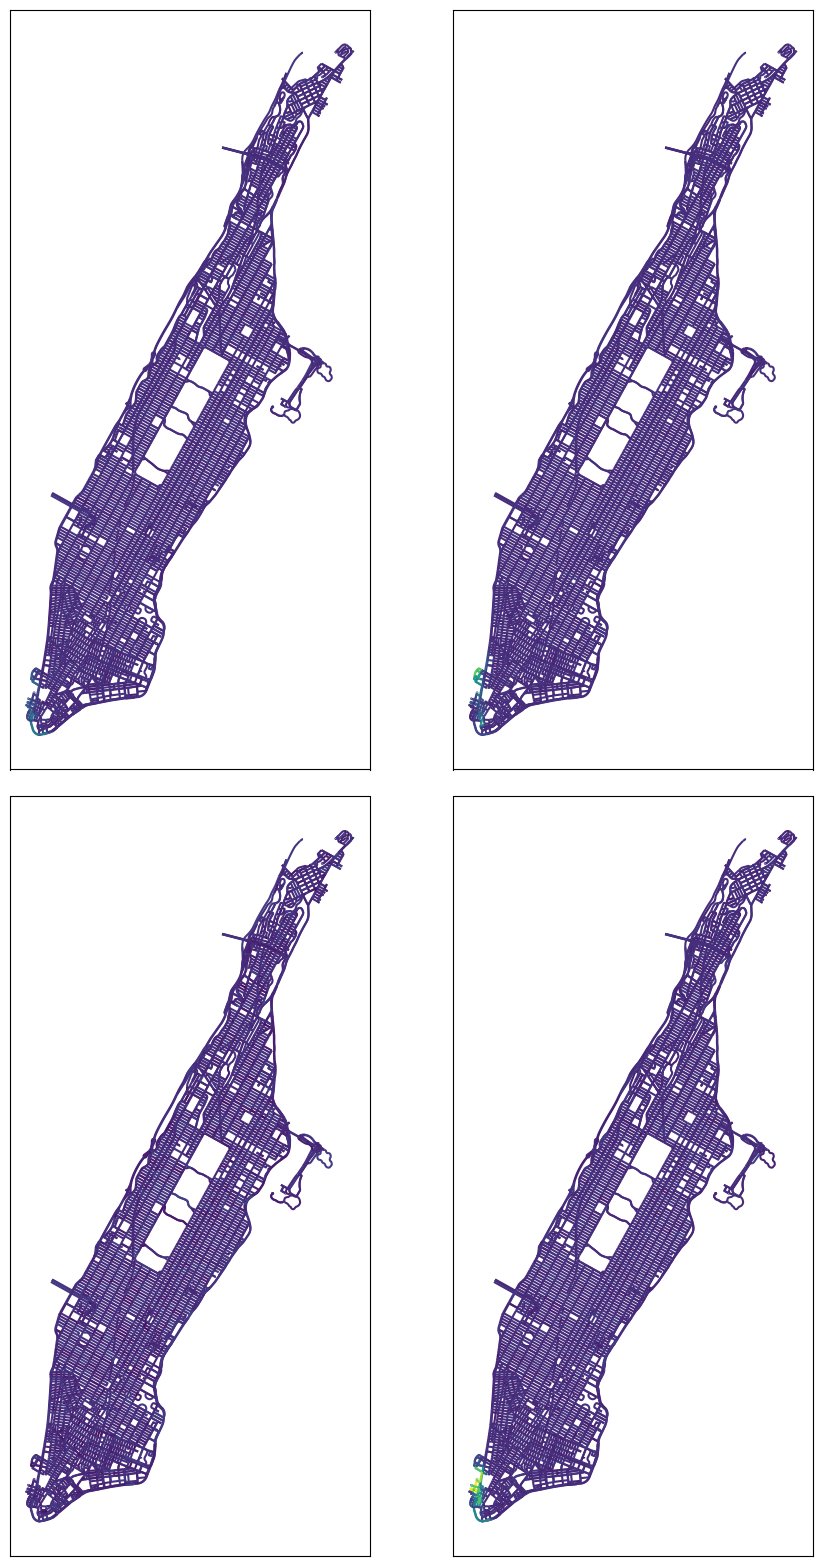

In [146]:
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,16))

# orig = list(G)[1]
# dest = list(G)[120]
# route_time = ox.shortest_path(G, orig, dest, weight="travel_time")
# route_rain = ox.shortest_path(G, orig, dest, weight="rain")

cluster_rp_vars = []
for samples_cluster_idx in range(N_rps):
    rp_samples = regions_samples[samples_clusters == samples_cluster_idx]
    rp_vars = np.log(np.std(rp_samples, axis=0))
    cluster_rp_vars.append(rp_vars)

vmin = np.min([np.min(cluster_rp_var) for cluster_rp_var in cluster_rp_vars])
vmax = np.max([np.max(cluster_rp_var) for cluster_rp_var in cluster_rp_vars])

for samples_cluster_idx in range(N_rps):
    nx.set_edge_attributes(G, dict(zip(G.edges, cluster_rp_vars[samples_cluster_idx])), name="rain_var")

    gdf_edges = ox.utils_graph.graph_to_gdfs(G, nodes=False)
    row_idx = samples_cluster_idx // ncols
    col_idx = samples_cluster_idx - ncols * row_idx
    gdf_edges.plot(ax=axs[row_idx, col_idx], cmap="viridis", column="rain_var", legend=False, vmin=vmin, vmax=vmax)

    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])
plt.tight_layout()